# Optimization in Julia

This lecture gives an overview of some optimization tools in Julia.

In [1]:
versioninfo()

Julia Version 1.4.0
Commit b8e9a9ecc6 (2020-03-21 16:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.6.0)
  CPU: Intel(R) Core(TM) i5-8279U CPU @ 2.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-8.0.1 (ORCJIT, skylake)


Commercial solvers [MOSEK](https://www.mosek.com) and [Gurobi](https://www.gurobi.com) need to be installed for this session.

The following Julia packages are also needed. 

In [2]:
using Pkg
Pkg.activate("../..")
Pkg.status()

 Activating environment at `~/Dropbox/class/M1399.000200/2020/Project.toml`


Status `~/Dropbox/class/M1399.000200/2020/Project.toml`
  [7d9fca2a] Arpack v0.4.0
  [6e4b80f9] BenchmarkTools v0.5.0
  [1e616198] COSMO v0.7.7
  [f65535da] Convex v0.13.7
  [31c24e10] Distributions v0.23.12
  [f6369f11] ForwardDiff v0.10.12
  [c91e804a] Gadfly v1.3.1
  [bd48cda9] GraphRecipes v0.5.4
  [2e9cd046] Gurobi v0.9.2
  [82e4d734] ImageIO v0.3.1
  [6218d12a] ImageMagick v1.1.6
  [916415d5] Images v0.23.1
  [b6b21f68] Ipopt v0.6.3
  [42fd0dbc] IterativeSolvers v0.8.4
  [4076af6c] JuMP v0.21.4
  [b51810bb] MatrixDepot v0.9.0-DEV #master (https://github.com/JuliaMatrices/MatrixDepot.jl.git)
  [6405355b] Mosek v1.1.3
  [1ec41992] MosekTools v0.9.4
  [76087f3c] NLopt v0.6.1
  [47be7bcc] ORCA v0.5.0
  [a03496cd] PlotlyBase v0.4.1
  [f0f68f2c] PlotlyJS v0.14.0
  [91a5bcdd] Plots v1.6.12
  [438e738f] PyCall v1.92.1
  [d330b81b] PyPlot v2.9.0
  [dca85d43] QuartzImageIO v0.7.3
  [6f49c342] RCall v0.13.9
  [c946c3f1] SCS v0.7.1
  [276daf66] SpecialFunctions v0.10.3
  [2913bbd2] StatsBase

Package `QuartzImageIO` is for macOS only.

## Flowchart

* Category of optimization problems:

    1. Problems with analytical solutions: least squares, principle component analysis, canonical correlation analysis, ...
    
    2. Problems subject to Disciplined Convex Programming (DCP): linear programming (LP), quadratic programming (QP), second-order cone programming (SOCP), semidefinite programming (SDP), and geometric programming (GP).
    
    3. Nonlinear programming (NLP): Newton type algorithms, Fisher scoring algorithm, EM algorithm, MM algorithms. 
    
    4. Large scale optimization: ADMM, SGD, ...
    
<img src="./optflow.png" width=400>

## Modeling tools and solvers

Getting familiar with **good** optimization softwares broadens the scope and scale of problems we are able to solve in statistics. Following table lists some of the best optimization softwares. 


|           |   | LP | MILP | SOCP |     MISOCP     | SDP | GP | NLP | MINLP |   | R | Matlab | Julia | Python |   | Cost |  
|:---------:|:-:|:--:|:----:|:----:|:--------------:|:---:|:--:|:---:|:-----:|:-:|:-:|:------:|:-----:|:------:|:-:|:----:|  
|   **modeling tools**   |   |    |      |      |                |     |    |     |       |   |   |        |       |        |   |      |  
|    AMPL   |   |  x |   x  |   x  |        x       |  x  |  x |  x  |   x   |   | x |    x   |       |    x   |   |   \$  |  
|    cvx    |   |  x |   x  |   x  |        x       |  x  |  x |     |       |   |   |    x   |       |    x   |   |   A  |  
| Convex.jl |   |  x |   x  |   x  |        x       |  x  |    |     |       |   |   |        |   x   |        |   |   O  |  
|  JuMP.jl  |   |  x |   x  |   x  |        x       |     |    |  x  |   x   |   |   |        |   x   |        |   |   O  |  
| MathProgBase.jl |   |  x |   x  |   x  |        x       |     |    |  x  |   x   |   |   |        |   x   |        |   |   O  |  
| MathOptInterface.jl |   |  x |   x  |   x  |        x       |     |    |  x  |   x   |   |   |        |   x   |        |   |   O  |  
|   **convex solvers** |   |    |      |      |                |     |    |     |       |   |   |        |       |        |   |      |  
|   Mosek   |   |  x |   x  |   x  |        x       |  x  |  x |  x  |       |   | x |    x   |   x   |    x   |   |   A  |  
|   Gurobi  |   |  x |   x  |   x  |        x       |     |    |     |       |   | x |    x   |   x   |    x   |   |   A  |  
|   CPLEX   |   |  x |   x  |   x  |        x       |     |    |     |       |   | x |    x   |   x   |    x   |   |   A  |  
|    SCS    |   |  x |      |   x  |                |  x  |    |     |       |   |   |    x   |   x   |    x   |   |   O  |  
|   **NLP solvers**  |   |    |      |      |                |     |    |     |       |   |   |        |       |        |   |      |  
|   NLopt   |   |  x |      |      |                |     |    |  x  |       |   |   |    x   |   x   |    x   |   |   O  |  
|   Ipopt   |   |  x |      |      |                |     |    |  x  |       |   |   |    x   |   x   |    x   |   |   O  |  
|   KNITRO  |   |  x |   x  |      |                |     |    |  x  |   x   |   | x |    x   |   x   |    x   |   |   $  |  

* O: open source  
* A: free academic license  
* $: commercial

## Difference between **modeling tools** and **solvers**

### Solvers

* Mosek, Gurobi, Cplex, SCS, etc are *concrete* software implementation of optimization algorithms. 
    - Mosek/Gurobi/SCS for convex optimization
    - Ipopt/NLopt for nonlinear programming
    - Mosek and Gurobi are commercial software but free for academic use. SCS/Ipopt/NLopt are open source.  

* Users need to implement the problem to solve using their application programming interface (API). [Example](https://docs.mosek.com/9.1/capi/_downloads/lo1.c)


### Modeling tools

* AMPL (comercial, <https://ampl.com>) is an algebraic modeling language that allows describe the optimization problem most close to its mathematical formulation. [Sample model](https://en.wikipedia.org/wiki/AMPL#A_sample_model)

* [cvx](http://cvxopt.org) (for Matlab) and [Convex.jl](https://github.com/jump-dev/Convex.jl) (Julia) implement the disciplined convex programming (DCP) paradigm proposed by [Grant and Boyd (2008)](http://stanford.edu/~boyd/papers/disc_cvx_prog.html). DCP prescribes a set of simple rules from which users can construct convex optimization problems easily.

* `Convex.jl` interfaces with actural problem solvers via [MathOptInterface](https://github.com/jump-dev/MathOptInterface.jl), an abstraction layer for mathematical optimization solvers in Julia.
    - For example, [MOSEK](https://www.mosek.com) is an actual interior-point solver for convex  and mixed-integer programs. It provides APIs that can be accessed in low-level using [Mosek.jl](https://github.com/MOSEK/Mosek.jl), which is abstractized by [MosekTools.jl](https://github.com/jump-dev/MosekTools.jl), which in turn implements `MathOptInterface`.
    
* Modeling tools usually have the capability to use a variety of solvers. But modeling tools are solver agnostic so users do not have to worry about specific solver interface.

## DCP Using Convex.jl

Standard convex problem classes like LP (linear programming), QP (quadratic programming), SOCP (second-order cone programming), SDP (semidefinite programming), and GP (geometric programming), are becoming a **technology**.

<img src="./cvxoptdiagram.png" width=300>

### Example: microbiome regression analysis -- compositional data

We illustrate optimization tools in Julia using microbiome analysis as an example.

Diversity of gut microbiome is believed to be an important factor for human health or diseases such as obesity; respiratory microbiome affects pulmonary function in an HIV-infected population.

16S microbiome sequencing techonology generates sequence counts of various organisms (operational taxonomic units, or OTUs) in samples. 

<img src="https://norgenbiotek.com/sites/default/files/services/16s-rrna-sq.jpg" width="300" align="center"/>    

The major interest is the **composition** of the microbiome in the population, hence 
for statistical analysis, OTU counts are normalized into **proportions** for each sample. 
Thus if there are $p$ OTUs, each observation $\mathbf{z}_i$ lies in the positive probability simplex $\Delta_{p-1,+}=\{z_1, \dotsc, z_p : z_j > 0, \sum_{j=1}^p z_j=1\}$. This unit-sum constraint introduces dependency between the $p$ variables, causing intrinsic difficulties in providing sensible interpretations for the regression parameters. A well-known resolution of this difficulty is the log-ratio transfomation due to Aitchson, which constructs the data matrix $\tilde{\mathbf{X}}=(\log\frac{z_{ij}}{z_{ip}}) \in \mathbb{R}^{n\times (p-1)}$. Thus the regression model is
$$
    \mathbf{y} = \tilde{\mathbf{X}}\tilde{\boldsymbol\beta} + \boldsymbol{\varepsilon}, \quad \tilde{\boldsymbol\beta} \in \mathbb{R}^{p-1}.
$$

By introducing an extra coefficient $\beta_p = -\sum_{j=1}^{p-1}\beta_j$, and letting $\mathbf{X}=(\log z_{ij})$, the above, assymetric model becomes symmetric:
$$
    \mathbf{y} = \mathbf{X}\boldsymbol{\beta} + \boldsymbol{\varepsilon}, \quad \boldsymbol{\beta} \in \mathbb{R}^{p}.
$$

### Zero-sum regression

In other words, we need to solve a **zero-sum least squares problem**  
$$
    \begin{array}{ll}
    \text{minimize} & \frac{1}{2} \|\mathbf{y} - \mathbf{X} \boldsymbol{\beta}\|_2^2 \\
    \text{subject to} & \mathbf{1}^T\boldsymbol{\beta} = 0.
    \end{array}
$$
For details, see

> Lin, W., Shi, P., Feng, R. and Li, H., 2014. Variable selection in regression with compositional covariates. Biometrika, 101(4), pp.785-797. <https://doi.org/10.1093/biomet/asu031>

The sum-to-zero contrained least squares is a standard quadratic programming (QP) problem so should be solved easily by any QP solver.

For simplicity we ignore intercept and non-OTU covariates in this presentation.

Let's first generate an artifical dataset:

In [3]:
using Random, LinearAlgebra, SparseArrays

Random.seed!(123) # seed

n, p = 100, 50
X = rand(n, p)
lmul!(Diagonal(1 ./ vec(sum(X, dims=2))), X)
β = sprandn(p, 0.1) # sparse vector with about 10% non-zero entries
y = X * β + randn(n);

#### Modeling using Convex.jl

We use the [Convex.jl](https://github.com/jump-dev/Convex.jl) package to model this QP problem. For a complete list of operations supported by Convex.jl, see how close the code is to the mathematical formulation above.

In [4]:
using Convex

β̂cls = Variable(size(X, 2))
problem = minimize(0.5sumsquares(y - X * β̂cls)) # objective
problem.constraints += sum(β̂cls) == 0; # sum-to-zero constraint

##### Mosek

We first use the Mosek solver to solve this QP.

In [5]:
using Mosek, MosekTools
opt = () -> Mosek.Optimizer(LOG=1)  # anonymous function
@time solve!(problem, opt)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 107             
  Cones                  : 2               
  Scalar variables       : 157             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimizat

In [6]:
# Check the status, optimal value, and minimizer of the problem
problem.status, problem.optval, β̂cls.value

(MathOptInterface.OPTIMAL, 26.450741793794975, [20.17363830989884; 2.118676448941195; … ; 24.140193669533474; -4.517825960973969])

##### Gurobi

Switch to [Gurobi](https://www.gurobi.com) solver:

In [7]:
ENV["GRB_LICENSE_FILE"]="/Users/jhwon/gurobi/gurobi.lic"  # set as YOUR path to license file

"/Users/jhwon/gurobi/gurobi.lic"

In [8]:
using Gurobi
const GRB_ENV = Gurobi.Env()
opt = () -> Gurobi.Optimizer(GRB_ENV)  # anonymous function
@time solve!(problem, opt)

Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (mac64)
Optimize a model with 107 rows, 157 columns and 5160 nonzeros
Model fingerprint: 0xe243cd86
Model has 2 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-05, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 3e+00]
Presolve removed 2 rows and 1 columns
Presolve time: 0.00s
Presolved: 105 rows, 156 columns, 5158 nonzeros
Presolved model has 2 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 50
 AA' NZ     : 5.154e+03
 Factor NZ  : 5.262e+03
 Factor Ops : 3.590e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.18451802e+01 -5.01000000e-01  2.40e+01 1.00e-01  2.10e-01     0s
   1   3.33648461e+00 -3.24029170e-0

In [9]:
# Check the status, optimal value, and minimizer of the problem
problem.status, problem.optval, β̂cls.value

(MathOptInterface.OPTIMAL, 26.450743119117902, [20.174776417650953; 2.1186615532700315; … ; 24.14219140188035; -4.519078491747891])

##### SCS

Switch to the open source [SCS](https://github.com/jump-dev/SCS.jl) solver:

In [10]:
# Use SCS solver
using SCS
opt = () -> SCS.Optimizer(verbose=1)  # anonymous function
@time solve!(problem, opt)

  5.280654 seconds (14.26 M allocations: 731.347 MiB, 5.79% gc time)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 5056, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 53, constraints m = 107
Cones:	primal zero / dual free vars: 2
	linear vars: 1
	soc vars: 104, soc blks: 2
Setup time: 2.76e-04s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.01e+20  5.75e+19  1.00e+00 -1.20e+21  8.21e+20  1.66e+21  5.35e-04 
   100| 1.25e-06  1.38e-06  1.69e-07  2.65e+01  2.

In [11]:
# Check the status, optimal value, and minimizer of the problem
problem.status, problem.optval, β̂cls.value

(MathOptInterface.OPTIMAL, 26.450639232450104, [20.17364374512858; 2.1185962604472524; … ; 24.140254779383294; -4.517748101542147])

##### COSMO

Switch to the open source [COSMO](https://oxfordcontrol.github.io/COSMO.jl/stable/) solver:

In [12]:
# Use COSMO solver
using COSMO
opt = () -> COSMO.Optimizer(max_iter=5000) # anonymous function
@time solve!(problem, opt)

------------------------------------------------------------------
          COSMO v0.7.7 - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2020
------------------------------------------------------------------

Problem:  x ∈ R^{53},
          constraints: A ∈ R^{107x53} (5056 nnz),
          matrix size to factor: 160x160,
          Floating-point precision: Float64
Sets:     SecondOrderCone of dim: 101
          SecondOrderCone of dim: 3
          ZeroSet of dim: 2
          Nonnegatives of dim: 1
Settings: ϵ_abs = 1.0e-04, ϵ_rel = 1.0e-04,
          ϵ_prim_inf = 1.0e-06, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1e-06, α = 1.6,
          max_iter = 5000,
          scaling iter = 10 (on),
          check termination every 40 iter,
          check infeasibility every 40 iter,
          KKT system solver: QDLDL
Setup Time: 880.65ms

Iter:	Objective:	Primal Res:	Dual Res:	Rho:
1	-2.4722e+00	5.8157e+00	3.6845e+0

In [13]:
# Check the status, optimal value, and minimizer of the problem
problem.status, problem.optval, β̂cls.value

(MathOptInterface.OPTIMAL, 26.306269427093532, [20.173638362541126; 2.118676454827778; … ; 24.140193716697027; -4.517825972726542])

### Zero-sum lasso

Suppose we want to know which organisms (OTUs) are associated with the response. We can answer this question using a zero-sum contrained lasso
$$
    \begin{array}{ll}
    \text{minimize} & \frac 12 \|\mathbf{y} - \mathbf{X} \boldsymbol{\beta}\|_2^2 + \lambda \|\boldsymbol{\beta}\|_1 \\
    \text{subject to} & \mathbf{1}^T\boldsymbol{\beta} = 0.
    \end{array}
$$

Varying $\lambda$ from small to large values will generate a solution path.

In [14]:
# Use Mosek solver
#opt = () -> Mosek.Optimizer(LOG=0)

## Use Gurobi solver
##solver = Gurobi.Optimizer(GRB_ENV)
#using JuMP
#opt = () -> Gurobi.Optimizer(GRB_ENV)
##model = direct_model(Gurobi.Optimizer(GRB_ENV))
##MOI.set(model, MOI.RawParameter("OutputFlag"), 0)
##set_optimizer_attribute(JuMP.Model(opt), "OutputFlag", 0)

# Use SCS solver
opt = () -> SCS.Optimizer(verbose=0)

## Use COSMO solver
#opt = () -> COSMO.Optimizer(max_iter=10000, verbose=false)

# solve at a grid of λ
λgrid = 0:0.01:0.35
β̂path = zeros(length(λgrid), size(X, 2)) # each row is β̂ at a λ
β̂classo = Variable(size(X, 2))
@time for i in 1:length(λgrid)
    λ = λgrid[i]
    # objective
    problem = minimize(0.5sumsquares(y - X * β̂classo) + λ * sum(abs, β̂classo))
    # constraint
    problem.constraints += sum(β̂classo) == 0 # constraint
    solve!(problem, opt)
    β̂path[i, :] = β̂classo.value
end

  2.239495 seconds (5.04 M allocations: 296.735 MiB, 5.06% gc time)


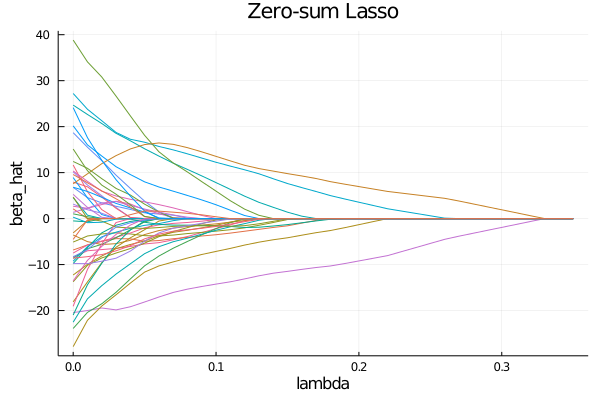

In [15]:
using Plots; gr()

p = plot(collect(λgrid), β̂path, legend=:none)
xlabel!(p, "lambda")
ylabel!(p, "beta_hat")
title!(p, "Zero-sum Lasso")

### Zero-sum group lasso

Suppose we want to do variable selection not at the OTU level, but at the Phylum level. OTUs are clustered into various Phyla. We can answer this question using a sum-to-zero contrained group lasso
$$
    \begin{array}{ll}
    \text{minimize} & \frac 12 \|\mathbf{y} - \mathbf{X} \boldsymbol{\beta}\|_2^2 + \lambda \sum_j \|\boldsymbol{\beta}_j\|_2 \\
    \text{subject to} & \mathbf{1}^T\boldsymbol{\beta} = 0,
    \end{array}
$$
where $\boldsymbol{\beta}_j$ is the $j$th partition of the regression coefficients corresponding to the $j$th phylum. This is a **second-order cone programming (SOCP)** problem readily modeled by Convex.jl.

Let's assume each 10 contiguous OTUs belong to one Phylum.

In [16]:
# Use Mosek solver
#opt = () -> Mosek.Optimizer(LOG=0)

## Use Gurobi solver
##solver = Gurobi.Optimizer(GRB_ENV)
#using JuMP
#opt = () -> Gurobi.Optimizer(GRB_ENV)
##model = direct_model(Gurobi.Optimizer(GRB_ENV))
##MOI.set(model, MOI.RawParameter("OutputFlag"), 0)
##set_optimizer_attribute(JuMP.Model(opt), "OutputFlag", 0)

# Use SCS solver
opt = () -> SCS.Optimizer(verbose=0)

## Use COSMO solver
#opt = () -> COSMO.Optimizer(max_iter=5000, verbose=false)


# solve at a grid of λ
λgrid = 0.1:0.005:0.5
β̂pathgrp = zeros(length(λgrid), size(X, 2)) # each row is β̂ at a λ
β̂classo = Variable(size(X, 2))
@time for i in 1:length(λgrid)
    λ = λgrid[i]
    # loss
    obj = 0.5sumsquares(y - X * β̂classo)
    # group lasso penalty term
    for j in 1:(size(X, 2)/10)
        βj = β̂classo[(10(j-1)+1):10j]
        obj = obj + λ * norm(βj)
    end
    problem = minimize(obj)
    # constraint
    problem.constraints += sum(β̂classo) == 0 # constraint
    solve!(problem, opt)
    β̂pathgrp[i, :] = β̂classo.value
end

  4.645598 seconds (7.35 M allocations: 458.390 MiB, 5.73% gc time)


It took Mosek <1 second to solve this seemingly hard optimization problem at **80** different $\lambda$ values.

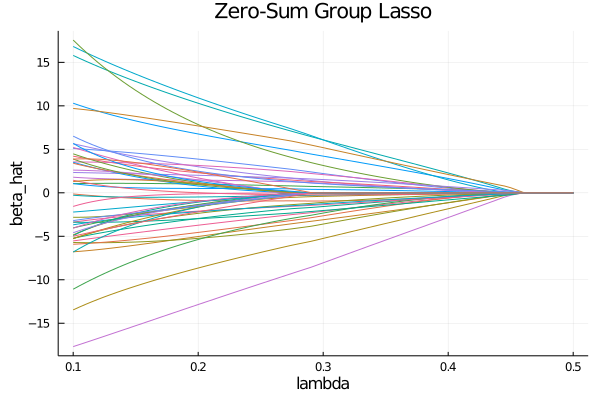

In [17]:
p2 = plot(collect(λgrid), β̂pathgrp, legend=:none)
xlabel!(p2, "lambda")
ylabel!(p2, "beta_hat")
title!(p2, "Zero-Sum Group Lasso")

### Example: matrix completion

Load the $128 \times 128$ [Lena](./lena128missing.png) image with missing pixels.

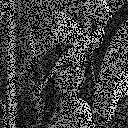

In [18]:
using Images

lena = load("lena128missing.png")

In [19]:
# convert to real matrices
Y = Float64.(lena)

128×128 Array{Float64,2}:
 0.0       0.0       0.635294  0.0       …  0.0       0.0       0.627451
 0.627451  0.623529  0.0       0.611765     0.0       0.0       0.388235
 0.611765  0.611765  0.0       0.0          0.403922  0.219608  0.0
 0.0       0.0       0.611765  0.0          0.223529  0.176471  0.192157
 0.611765  0.0       0.615686  0.615686     0.0       0.0       0.0
 0.0       0.0       0.0       0.619608  …  0.0       0.0       0.2
 0.607843  0.0       0.623529  0.0          0.176471  0.192157  0.0
 0.0       0.0       0.623529  0.0          0.0       0.0       0.215686
 0.619608  0.619608  0.0       0.0          0.2       0.0       0.207843
 0.0       0.0       0.635294  0.635294     0.2       0.192157  0.188235
 0.635294  0.0       0.0       0.0       …  0.192157  0.180392  0.0
 0.631373  0.0       0.0       0.0          0.0       0.0       0.0
 0.0       0.627451  0.635294  0.666667     0.172549  0.0       0.184314
 ⋮                                       ⋱  ⋮          

We fill out the missing pixels uisng a **matrix completion** technique developed by Candes and Tao
$$
    \begin{array}{ll}
    \text{minimize} & \|\mathbf{X}\|_* \\
    \text{subject to} & x_{ij} = y_{ij} \text{ for all observed entries } (i, j).
    \end{array}
$$

Here $\|\mathbf{X}\|_* = \sum_{i=1}^{\min(m,n)} \sigma_i(\mathbf{X})$ is the nuclear norm. It can be shown that 
$$
\|\mathbf{X}\|_* = \sup_{\|\mathbf{Y}\|_2 \le 1} \langle \mathbf{X}, \mathbf{Y} \rangle,
$$ 
where $\|\mathbf{Y}\|_2=\sigma_{\max}(\mathbf{Y})$ is the spectral (operator 2-) norm, and $\langle \mathbf{X}, \mathbf{Y} \rangle = \text{tr}(\mathbf{X}^T\mathbf{Y})$. That is, $\|\cdot\|_*$ is the dual norm of $\|\cdot\|_2$.

The nuclear norm can be considered as the best convex approximation to $\text{rank}(M)$, just like $\|\mathbf{x}\|_1$ is the best convex approximation to $\|\mathbf{x}\|_0$.
We want the matrix with the lowest rank that agrees with the observed entries, but instead seek one with the minimal nuclear norm as a convex relaxation.

This is a **semidefinite programming (SDP)** problem readily modeled by Convex.jl.

This example takes **long** because of high dimensionality.

In [20]:
# Use COSMO solver
using COSMO
opt = () -> COSMO.Optimizer()
## Use SCS solver
#using SCS
#opt = () -> SCS.Optimizer()
## Use Mosek solver
#using Mosek
#opt = () -> Mosek.Optimizer()

# Linear indices of obs. entries
obsidx = findall(Y[:] .≠ 0.0)
# Create optimization variables
X = Convex.Variable(size(Y))
# Set up optmization problem
problem = minimize(nuclearnorm(X))
problem.constraints += X[obsidx] == Y[obsidx]
# Solve the problem by calling solve
@time solve!(problem, opt)

------------------------------------------------------------------
          COSMO v0.7.7 - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2020
------------------------------------------------------------------

Problem:  x ∈ R^{49153},
          constraints: A ∈ R^{73665x49153} (73793 nnz),
          matrix size to factor: 122818x122818,
          Floating-point precision: Float64
Sets:     ZeroSet of dim: 40769
          DensePsdConeTriangle of dim: 32896
Settings: ϵ_abs = 1.0e-04, ϵ_rel = 1.0e-04,
          ϵ_prim_inf = 1.0e-06, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1e-06, α = 1.6,
          max_iter = 2500,
          scaling iter = 10 (on),
          check termination every 40 iter,
          check infeasibility every 40 iter,
          KKT system solver: QDLDL
Setup Time: 49.06ms

Iter:	Objective:	Primal Res:	Dual Res:	Rho:
1	-1.4426e+03	1.1678e+01	5.9856e-01	1.0000e-01
40	1.4739e+02	1.7996e-02	2.4732

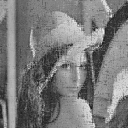

In [21]:
colorview(Gray, X.value)

## Nonlinear programming (NLP)

We use MLE of Gamma distribution to illustrate some rudiments of nonlinear programming (NLP) in Julia. 

Let $x_1,\ldots,x_m$ be a random sample from the gamma density with shape parameter $\alpha$ and rate parameter $\beta$:
$$
f(x) = \Gamma(\alpha)^{-1} \beta^{\alpha} x^{\alpha-1} e^{-\beta x}
$$
on $(0,\infty)$. The log likelihood function is
$$
    L(\alpha, \beta) = m [- \ln \Gamma(\alpha) + \alpha \ln \beta + (\alpha - 1)\overline{\ln x} - \beta \bar x],
$$
where $\overline{x} = \frac{1}{m} \sum_{i=1}^m x_i$ and 
$\overline{\ln x} = \frac{1}{m} \sum_{i=1}^m \ln x_i$.

In [22]:
using Random, Statistics, SpecialFunctions
Random.seed!(280)

function gamma_logpdf(x::Vector, α::Real, β::Real)
    m = length(x)
    avg = mean(x)
    logavg = sum(log, x) / m
    m * (- loggamma(α) + α * log(β) + (α - 1) * logavg - β * avg)
end

x = rand(5)
gamma_logpdf(x, 1.0, 1.0)

-2.7886541275400365

Many optimization algorithms involve taking derivatives of the objective function. The `ForwardDiff.jl` package implements automatic differentiation. For example, to compute the derivative and Hessian of the log-likelihood with data `x` at `α=1.0` and `β=1.0`.

In [23]:
using ForwardDiff
ForwardDiff.gradient(θ -> gamma_logpdf(x, θ...), [1.0; 1.0])

2-element Array{Float64,1}:
 -1.058800554530917
  2.2113458724599635

In [24]:
ForwardDiff.hessian(θ -> gamma_logpdf(x, θ...), [1.0; 1.0])

2×2 Array{Float64,2}:
 -8.22467   5.0
  5.0      -5.0

Generate data:

In [25]:
using Distributions, Random

Random.seed!(280)
(n, p) = (1000, 2)
(α, β) = 5.0 * rand(p)
x = rand(Gamma(α, β), n)
println("True parameter values:")
println("α = ", α, ", β = ", β)

True parameter values:
α = 0.5535947086407722, β = 4.637963827225865


We use [JuMP.jl](https://github.com/jump-dev/JuMP.jl) to define and solve our NLP problem.

Recall that we want to solve the optimization problem:
$$
\begin{array}{ll}
    \text{maximize} & L(\alpha, \beta)= m [- \ln \Gamma(\alpha) + \alpha \ln \beta + (\alpha - 1)\overline{\ln x} - \beta \bar x] \\
    \text{subject to} & \alpha \ge 0 \\
    ~ & \beta \ge 0
\end{array}
$$

Observe the similarity and difference in modeling with [Convex.jl](https://github.com/jump-dev/Convex.jl):

In [26]:
using JuMP, Ipopt, NLopt

#m = Model(with_optimizer(Ipopt.Optimizer, print_level=3))
m = Model(
           optimizer_with_attributes(
               NLopt.Optimizer, "algorithm" => :LD_MMA
           )
       )

myf(a, b) = gamma_logpdf(x, a, b)
JuMP.register(m, :myf, 2, myf, autodiff=true)
@variable(m, α >= 1e-8)
@variable(m, β >= 1e-8)
@NLobjective(m, Max, myf(α, β))

print(m)
status = JuMP.optimize!(m)

println("MLE (JuMP):")
println("α = ", JuMP.value(α), ", β = ", JuMP.value(β))
println("Objective value: ", JuMP.objective_value(m))

Max myf(α, β)
Subject to
 α ≥ 1.0e-8
 β ≥ 1.0e-8
MLE (JuMP):
α = 0.5489638225056421, β = 0.20038521795826567
Objective value: -1853.384817360246


Then convert the rate parameter to the scale parameter to compare the result with `fit_mle()` in the `Distribution` package:

In [27]:
println("α = ", JuMP.value(α), ", θ = ", 1 / JuMP.value(β))
println("MLE (Distribution package):")
println(fit_mle(Gamma, x))

α = 0.5489638225056421, θ = 4.990388064494211
MLE (Distribution package):
Gamma{Float64}(α=0.5489317142213413, θ=4.990963923701522)


## Acknowledgment

Many parts of this lecture note is based on [Dr. Hua Zhou](http://hua-zhou.github.io)'s 2019 Spring Statistical Computing course notes available at <http://hua-zhou.github.io/teaching/biostatm280-2019spring/index.html>.